# Age, Gender & Ethnicity Prediction

In this notebook, I'm going to do image classification and try to predict 3 different target variables: gender, ethnicity and age with 3 separate models. 

The data took from Kaggle and here's the [DIRECT LINK](https://https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv).


This dataset includes a CSV of facial images that are labeled on the basis of age, gender, and ethnicity.
The dataset includes 27305 rows and 5 columns.
The pictures are formated in 48X48 pixels in a grayscale.

There are three targets:

- Age: range from 1 to 116

- Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other

- Gender: 0 - male, 1 - female


First, I'm going to deal with gender classification by using: 
- Simple fully connected network with hyperparameter search.

- Simple convolutional network.

- Data augmentation technique in try to improve the convolutional network.

Then, I will try to predict the ethnicity of the person in the image (which is harder because it's 5 classes) with the convolutional network.

At last, I will try to predict the age of the person in the image, which is a regression problem. I use:
- The convolutional network with the same architecture from earlier (almost).

- VGG19 architecture.

- Resnet50 architecture.

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Flatten, Activation, Add, Dense, Input, Dropout, Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization,GlobalAveragePooling2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras.models import Model, load_model



np.random.seed(1234)
tf.random.set_seed(1234)

### Importing the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Exploratory Data Analysis

In [ ]:
data.shape

(23705, 5)

### Age Variable

In [ ]:
data['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [ ]:
np.array(sorted(data['age'].unique()))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  96,  99, 100, 101, 103, 105, 110, 111, 115, 116])

Text(0.5, 1.0, 'Age Distribution')

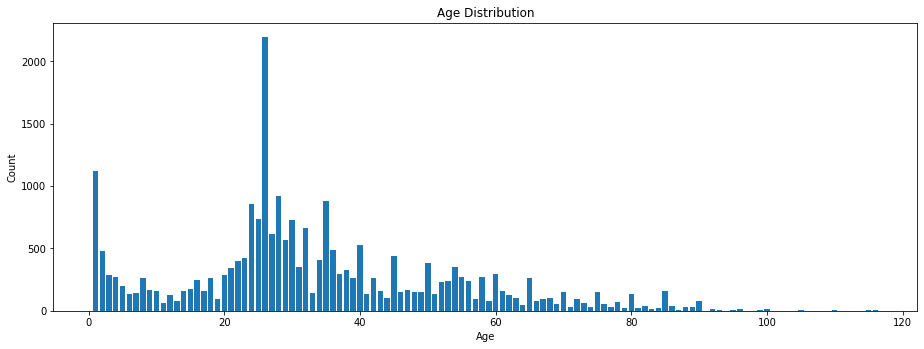

In [ ]:
index = data['age'].value_counts().index
val = data['age'].value_counts().values

fig = plt.figure()
ax = fig.add_axes([1,2,2,1])

ax.bar(index, val)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Age Distribution')

### Ethnicity Variable

In [ ]:
data['ethnicity'].describe()

count    23705.000000
mean         1.269226
std          1.345638
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: ethnicity, dtype: float64

In [ ]:
data['ethnicity'].unique()

array([2, 3, 4, 0, 1])

Text(0.5, 1.0, 'Ethnicity Distribution')

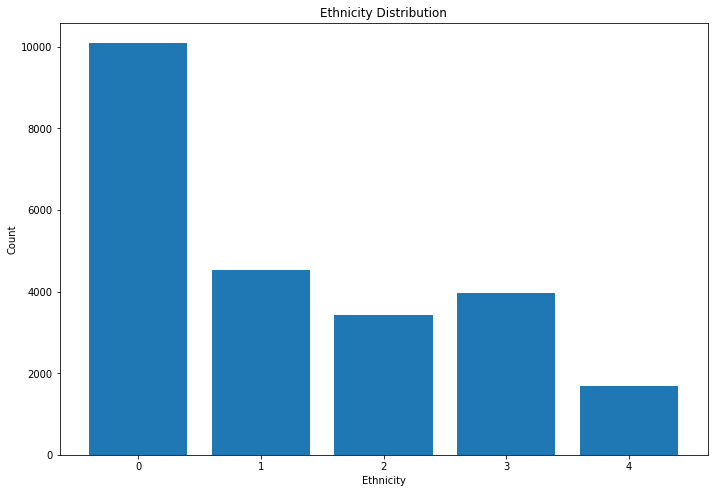

In [ ]:
index = data['ethnicity'].value_counts().index
val = data['ethnicity'].value_counts().values

fig = plt.figure()
ax = fig.add_axes([1.5,1.5,1.5,1.5])

ax.bar(index, val)
ax.set_xlabel('Ethnicity')
ax.set_ylabel('Count')
ax.set_title('Ethnicity Distribution')

### Gender Variable


In [ ]:
data['gender'].describe()

count    23705.000000
mean         0.477283
std          0.499494
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [ ]:
data['gender'].unique()

array([0, 1])

Text(0.5, 1.0, 'Gender Distribution')

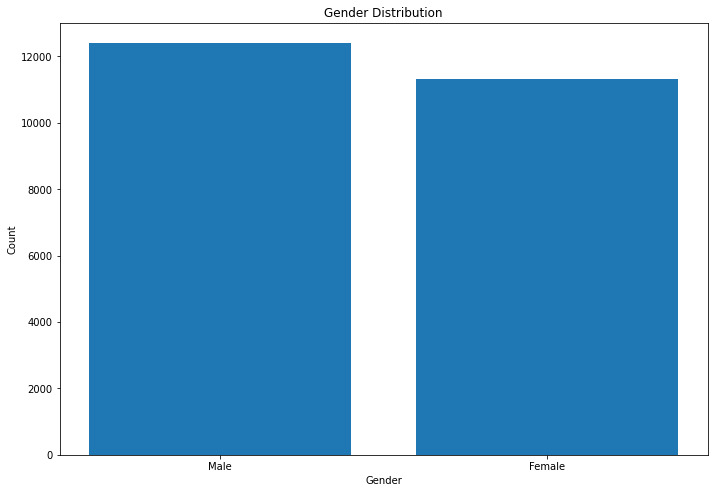

In [ ]:
index = data['gender'].value_counts().rename(index={0:'Male',1:'Female'}).index
val = data['gender'].value_counts().values

fig = plt.figure()
ax = fig.add_axes([1.5,1.5,1.5,1.5])

ax.bar(index, val,)
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution')

Fix the pixels variable.

In [ ]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

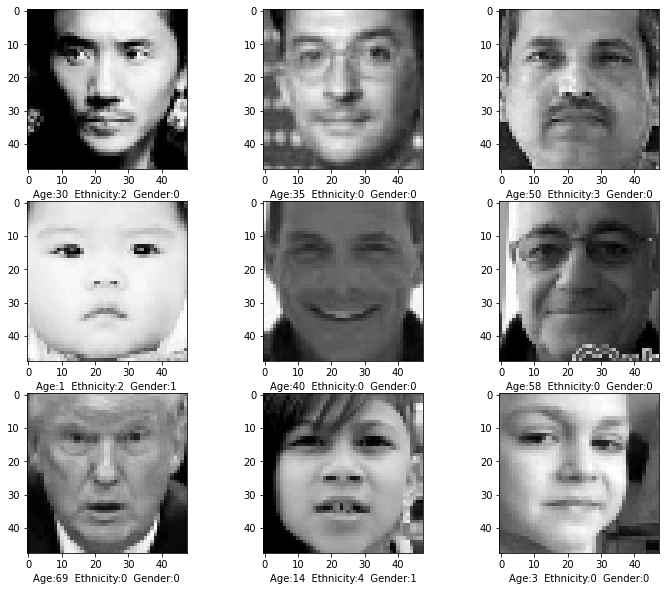

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for i in random.sample(range(1,data.shape[0],1), k=9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(data.loc[i,'pixels'].reshape(48,48),cmap=plt.get_cmap('gray'))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )

plt.show()

# Gender Prediction Model

Splitting and preprocessing the data.

In [ ]:
# Converting pixels from 1D to 3D
data['pixels'] = data['pixels'].apply(lambda x: x/255)
X = np.array(data['pixels'].tolist())
X = X.reshape(X.shape[0],48,48,1)

In [ ]:
y = to_categorical(np.array(data['gender']))

# Here I split original training data to sub-training (90%) and test data (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

# Here I split new training data to sub-training (75%) and validation data (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1234)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(16000, 48, 48, 1)
(5334, 48, 48, 1)
(2371, 48, 48, 1)


### Build a fully connected Vanilla model

In [ ]:
def fc_model(n_hidden=6, n_neurons=20, learning_rate=1e-3, input_shape=(48,48,1)):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="elu", **options))
        options = {}
    model.add(Flatten())    
    model.add(keras.layers.Dense(2, activation='softmax', **options))
    optimizer = Adam(learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(fc_model)

**Note**: It seems to be a bug in keras or scikit_learn that occurs with nested arrays as parameters for the grid search. I tried to solve it by nesting **tuples** instead of arrays but it does'nt worked.

In [ ]:
%%time

# Setting the parameters ranges
params = {
    "n_hidden": tuple(range(1,6)),   
    "n_neurons": tuple(range(10,100,10)),
    "learning_rate": tuple(np.random.uniform(1e-2, 1e-6, 50))
}

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=6, verbose=0)
mcp = ModelCheckpoint(filepath='weights1.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=0)

# Random search grid 
rnd_search = RandomizedSearchCV(keras_clf, params, random_state=1234, n_iter=20,
                                cv=ShuffleSplit(n_splits=1, test_size= 0.001, random_state=1234)) # for none cross-validation

rnd_search.fit(X_train, y_train, epochs=50,
                  validation_data=(X_val, y_val),
                  callbacks=[es, mcp, rlr],
                  verbose=0)

1/1 [==============================] - 0s 2ms/step - loss: 0.3932 - accuracy: 0.8125


RuntimeError: ignored

In [ ]:
print(rnd_search.best_params_)

{'n_neurons': 50, 'n_hidden': 2, 'learning_rate': 0.00944999105233317}


In [ ]:
%%time

# Assign the best parameters to the new model
model = fc_model(n_hidden=2, n_neurons=50, learning_rate=0.00945)

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)

history = model.fit(X_train, y_train, epochs=50,
                  validation_data=(X_val, y_val),
                  callbacks=[es, rlr, mcp],
                  verbose=1)

Epoch 1/50
494/500 [============================>.] - ETA: 0s - loss: 0.9239 - accuracy: 0.7664
Epoch 00001: val_loss improved from inf to 0.45561, saving model to weights1.h5
500/500 [==============================] - 5s 10ms/step - loss: 0.9182 - accuracy: 0.7667 - val_loss: 0.4556 - val_accuracy: 0.7816
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7984
Epoch 00002: val_loss improved from 0.45561 to 0.44273, saving model to weights1.h5
500/500 [==============================] - 5s 10ms/step - loss: 0.5135 - accuracy: 0.7984 - val_loss: 0.4427 - val_accuracy: 0.8180
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8156
Epoch 00003: val_loss did not improve from 0.44273
500/500 [==============================] - 5s 10ms/step - loss: 0.5104 - accuracy: 0.8156 - val_loss: 0.4562 - val_accuracy: 0.7711
Epoch 4/50
498/500 [============================>.] - ETA: 0s - loss: 0.9688 - accuracy: 0.7969
Epoch

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3685942590236664
Test accuracy: 0.8371995091438293


### Create custom function for plot the model history

In [ ]:
def plot_history(History,Metric = 'accuracy'):
    metric = History.history[Metric]
    val_metric = History.history['val_'+ str(Metric)]
    loss = History.history['loss']
    val_loss = History.history['val_loss']
    epochs = range(len(metric))

    plt.plot(epochs, metric, 'r--', label='Training ' + str(Metric))
    plt.plot(epochs, val_metric, 'b', label='Validation ' + str(Metric))
    plt.title('Training and validation '+ str(Metric))
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

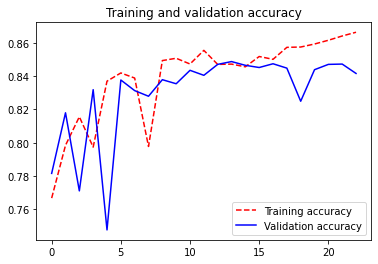

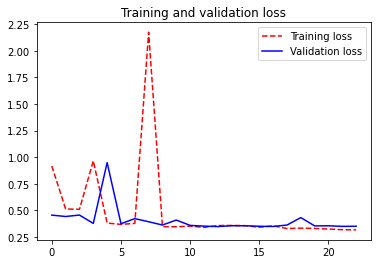

In [ ]:
plot_history(history)

## Create custom function for plot the confusion matrix

I took this function code from [this](https://www.kaggle.com/agungor2/various-confusion-matrix-plots) karnel.  

In [ ]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, cbar=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[1043  165]
 [ 221  942]] 

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1208
         1.0       0.85      0.81      0.83      1163

    accuracy                           0.84      2371
   macro avg       0.84      0.84      0.84      2371
weighted avg       0.84      0.84      0.84      2371
 



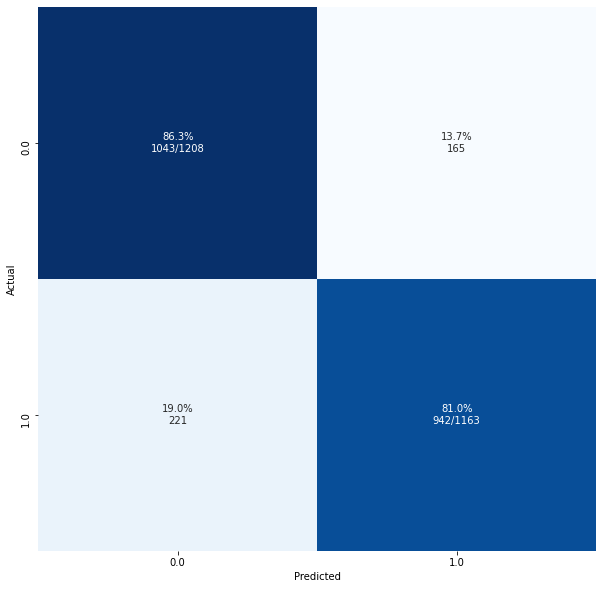

In [ ]:
pred = model.predict_classes(X_test)
y_true=pd.DataFrame(y_test)[1]

#Create the report and confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm,'\n')
print(classification_report(y_true, pred),'\n')

plot_cm(y_true, pred)

## Build a convolutional neural network model

- The Conv2D layers are used for the convolution operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map.

- The MaxPooling2D layers are used for the max-pooling operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. 

- The BatchNormalization layers is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling, which in turn improves the performance.

- Activation: exponential linear unit (ELU).

- The Dropout layer is randomly disabling neurons in the learning phase. This method is used to reduce overfitting.

In [ ]:
def conv_model(last_activation='softmax',n_class=2, n_neurons=500, input_shape=(48,48,1), loss="binary_crossentropy", metric='accuracy', learning_rate=1e-3):
    model = Sequential([
                        
        Conv2D(18, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('elu'),
 
        Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(n_neurons),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.5),
        
        Dense(n_neurons),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),
        
        Dense(n_class, activation=last_activation)
    ])

    model.compile(optimizer= Adam(lr=learning_rate),
                  loss=loss,
                  metrics=[metric])
    return model

In [ ]:
model2 = conv_model()
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 18)        180       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 18)        72        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 18)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        5216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [ ]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)

history2 = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data = (X_val, y_val),
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
496/500 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8138
Epoch 00001: val_loss improved from inf to 0.34771, saving model to weights2.h5
500/500 [==============================] - 7s 15ms/step - loss: 0.4361 - accuracy: 0.8141 - val_loss: 0.3477 - val_accuracy: 0.8500
Epoch 2/50
496/500 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8734
Epoch 00002: val_loss improved from 0.34771 to 0.28762, saving model to weights2.h5
500/500 [==============================] - 7s 14ms/step - loss: 0.2965 - accuracy: 0.8730 - val_loss: 0.2876 - val_accuracy: 0.8755
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8907
Epoch 00003: val_loss did not improve from 0.28762
500/500 [==============================] - 6s 13ms/step - loss: 0.2586 - accuracy: 0.8906 - val_loss: 0.5780 - val_accuracy: 0.7655
Epoch 4/50
499/500 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.8960
Epoch

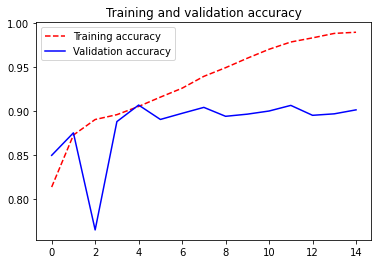

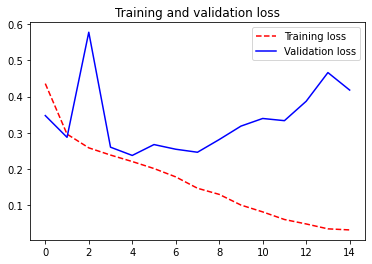

In [ ]:
plot_history(history2)

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3680526316165924
Test accuracy: 0.9093209505081177


Acuuracy improved from 83.712% to 90.09%!

## Classification Report

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[1111   97]
 [ 118 1045]] 

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1208
         1.0       0.92      0.90      0.91      1163

    accuracy                           0.91      2371
   macro avg       0.91      0.91      0.91      2371
weighted avg       0.91      0.91      0.91      2371
 



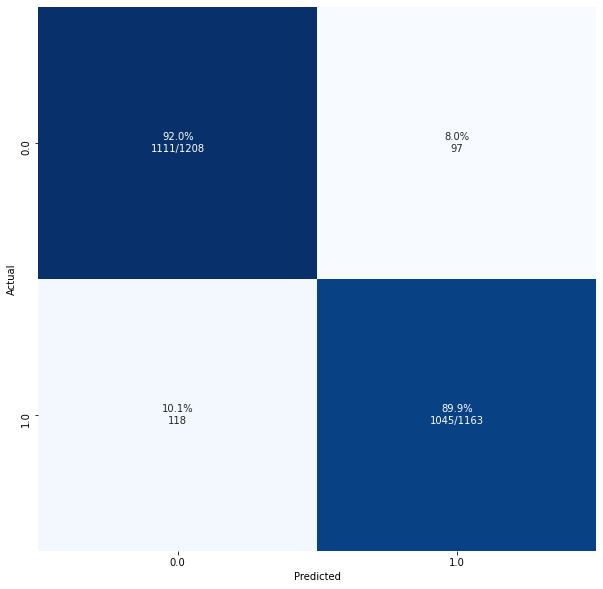

In [ ]:
pred = model2.predict_classes(X_test)
y_true=pd.DataFrame(y_test)[1]

#Create the report and confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm,'\n')
print(classification_report(y_true, pred),'\n')

plot_cm(y_true, pred)

## Data Augmentation

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. 
It generates samples by rotating, shifting and zooming on the training samples, and training for another 50 epochs, it helps reduce overfitting.

In [ ]:
# Train
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_datagen.fit(X_train)
batches = train_datagen.flow(X_train, y_train, batch_size=32)

# Validation
val_datagen = ImageDataGenerator()
val_datagen.fit(X_train)
val_batches = val_datagen.flow(X_val, y_val, batch_size=32)


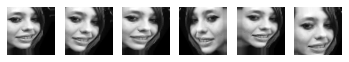

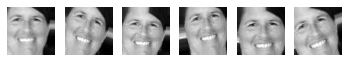

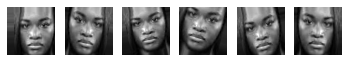

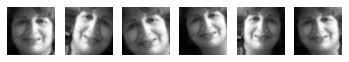

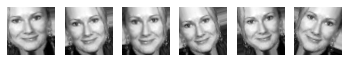

In [ ]:
for j in random.sample(range(1,1000,1), k=5):
    pic = train_datagen.flow(X_train[j:j+1], batch_size=1)

    for i in range(1, 7):
        plt.subplot(1,6,i)
        plt.axis("off")
        plt.imshow(pic.next().squeeze(), cmap=plt.get_cmap('gray'))
        plt.plot()
    plt.show()

In [ ]:
model3 = conv_model()

In [ ]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights3.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)


steps_per_epoch = batches.n // batches.batch_size
validation_steps = val_batches.n // val_batches.batch_size

history3 = model3.fit_generator(batches,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = val_batches,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.6785
Epoch 00001: val_loss improved from inf to 0.54821, saving model to weights3.h5
500/500 [==============================] - 13s 26ms/step - loss: 0.6551 - accuracy: 0.6785 - val_loss: 0.5482 - val_accuracy: 0.7419
Epoch 2/50
499/500 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.7768
Epoch 00002: val_loss improved from 0.54821 to 0.34984, saving model to weights3.h5
500/500 [==============================] - 12s 24ms/step - loss: 0.4743 - accuracy: 0.7769 - val_loss: 0.3498 - val_accuracy: 0.8483
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8088
Epoch 00003: val_loss improved from 0.34984 to 0.33060, saving model to weights3.h5
500/500 [==============================] - 12s 25ms/step - loss: 0.4155 - accuracy: 0.8087 - val_loss: 0.3306 - val_accura

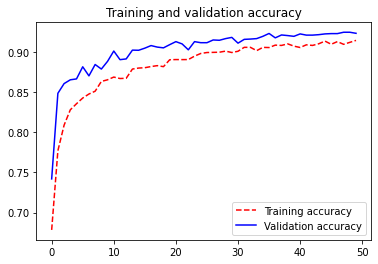

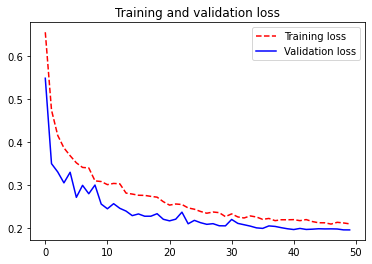

In [ ]:
plot_history(history3)

In [ ]:
score = model3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18881334364414215
Test accuracy: 0.9240826368331909


Acuuracy improved from 90.09% to 92.4%!

[[1111   97]
 [  83 1080]] 

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      1208
         1.0       0.92      0.93      0.92      1163

    accuracy                           0.92      2371
   macro avg       0.92      0.92      0.92      2371
weighted avg       0.92      0.92      0.92      2371
 



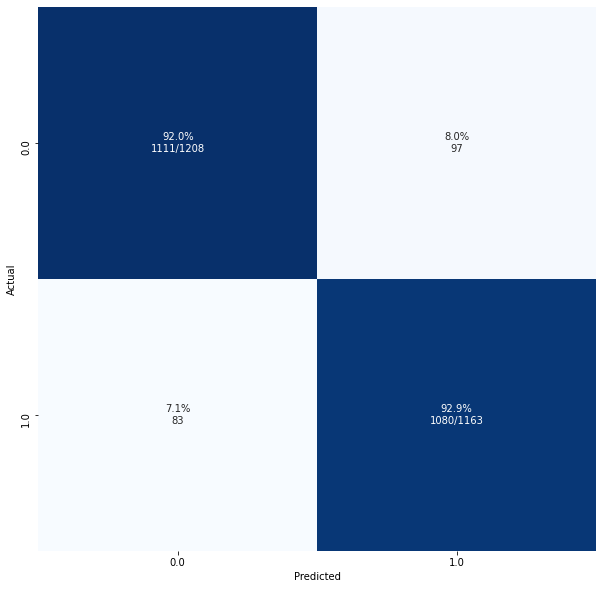

In [ ]:
pred = model3.predict_classes(X_test)
y_true=pd.DataFrame(y_test)[1]

#Create the report and confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm,'\n')
print(classification_report(y_true, pred),'\n')

plot_cm(y_true, pred)

# Ethnicity Prediction Model

In [ ]:
# Reshape back to the original shape 48x48x1
X = np.array(data['pixels'].tolist())
X = X.reshape(X.shape[0],48,48,1)

# Now the target variable is ethnicity
y = to_categorical(np.array(data['ethnicity']))

# Here I split original training data to sub-training (85%) and test data (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=1234)

# Here I split new training data to sub-training (85%) and validation data (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=1234)

In [ ]:
# Train
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_datagen.fit(X_train)
batches = train_datagen.flow(X_train, y_train, batch_size=32)

# Validation
val_datagen = ImageDataGenerator()
val_datagen.fit(X_train)
val_batches = val_datagen.flow(X_val, y_val, batch_size=32)


###Unbalanced Data

In [ ]:
data['ethnicity'].value_counts(normalize=True)

0    0.425142
1    0.190930
3    0.167686
2    0.144864
4    0.071377
Name: ethnicity, dtype: float64

We can notice that our target variable is not balanced, therefore 'accuracy' matric is not appropriate this time. Hence, we need to track after other matrics like the F1 score. Because Keras has no build-in F1 matric so it's necessary to create one manually. I took the f1_score function code from [HERE](https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

\begin{equation*}
F1 = \frac{2 \cdot precision\cdot recall}{precision+ recall}
\end{equation*}


In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Using the same custom conv model but change the loss to categorical_crossentropy because the number of classes is 5 now.
Moreover, we using the custom f1_score function as the metrics. 

In [ ]:
model4 = conv_model(n_class=5, loss="categorical_crossentropy", metric=f1_score)
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 18)        180       
_________________________________________________________________
batch_normalization_14 (Batc (None, 48, 48, 18)        72        
_________________________________________________________________
activation_14 (Activation)   (None, 48, 48, 18)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 32)        5216      
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

In [ ]:
%%time

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights4.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)


steps_per_epoch = batches.n // batches.batch_size
validation_steps = val_batches.n // val_batches.batch_size

history4 = model4.fit_generator(batches,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = val_batches,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
533/535 [============================>.] - ETA: 0s - loss: 1.3593 - f1_score: 0.4430
Epoch 00001: val_loss improved from inf to 1.03669, saving model to weights4.h5
535/535 [==============================] - 13s 24ms/step - loss: 1.3593 - f1_score: 0.4429 - val_loss: 1.0367 - val_f1_score: 0.6060
Epoch 2/50
535/535 [==============================] - ETA: 0s - loss: 1.0875 - f1_score: 0.5623
Epoch 00002: val_loss did not improve from 1.03669
535/535 [==============================] - 12s 23ms/step - loss: 1.0875 - f1_score: 0.5623 - val_loss: 1.4461 - val_f1_score: 0.4861
Epoch 3/50
533/535 [============================>.] - ETA: 0s - loss: 0.9777 - f1_score: 0.6236
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 00003: val_loss did not improve from 1.03669
535/535 [==============================] - 12s 23ms/step - loss: 0.9778 - f1_score: 0.6234 - val_loss: 1.0991 - val_f1_score: 0.6438
Epoch 4/50
533/535 [============================>.

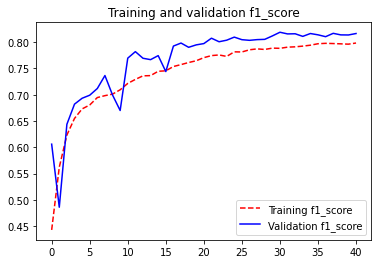

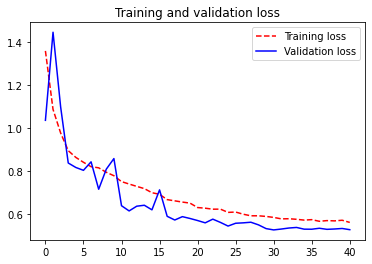

In [ ]:
plot_history(History=history4, Metric='f1_score')

#### Reversing 'one-hot' encoding to labels

In [ ]:
def one_hot_to_labels(data):
    labels = []
    for i in data:
        labels.append(list(i).index(1))
    return labels

[[1407   32   19   36   18]
 [  26  630    7   11    5]
 [  33   18  437   12   15]
 [ 101   57    9  411   18]
 [ 122   36   10   42   44]] 

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1512
           1       0.82      0.93      0.87       679
           2       0.91      0.85      0.88       515
           3       0.80      0.69      0.74       596
           4       0.44      0.17      0.25       254

    accuracy                           0.82      3556
   macro avg       0.76      0.71      0.72      3556
weighted avg       0.81      0.82      0.81      3556
 



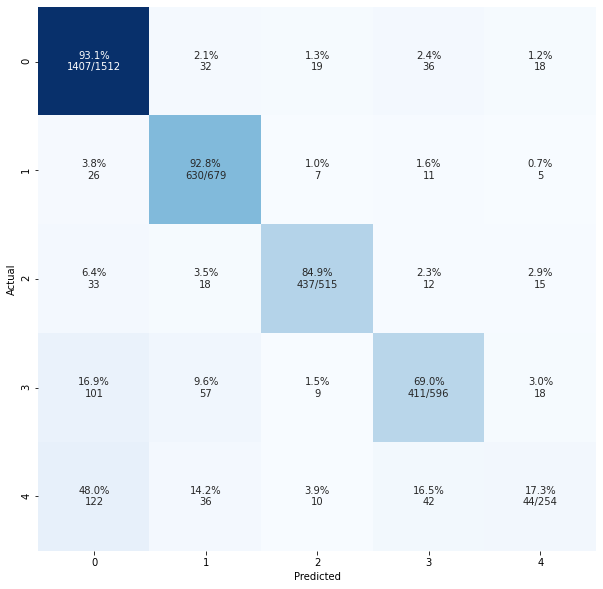

In [ ]:
pred = model4.predict_classes(X_test)

y_true=pd.Series(one_hot_to_labels(y_test))

#Create the report and confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm,'\n')
print(classification_report(y_true, pred),'\n')
plot_cm(y_true, pred)

In [ ]:
score = model4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test F1 score:', score[1])

Test loss: 0.5259724259376526
Test F1 score: 0.8254548907279968


It seems the model has difficulties with correctly classifying the fifth class. Maybe it's because the fifth class is actually classified as "others" which could be multiple ethnicities.

# Age Prediction Model

In [ ]:
# Reshape back to the original shape 48x48x1
X = np.array(data['pixels'].tolist())
X = X.reshape(X.shape[0],48,48,1)

# Now the target variable is ethnicity
y = np.array(data['age'])

# Here I split original training data to sub-training (85%) and test data (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

# Here I split new training data to sub-training (85%) and validation data (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1234)

###Data Augmentation

In [ ]:
# Train
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_datagen.fit(X_train)
batches = train_datagen.flow(X_train, y_train, batch_size=32)

# Validation
val_datagen = ImageDataGenerator()
val_datagen.fit(X_train)
val_batches = val_datagen.flow(X_val, y_val, batch_size=32)


This time we dealing with a regression problem and no classification therefore we use mean squared error loss instead of categorical cross-entropy and we use mean absolute error for matrics.

In [ ]:
# The model
model5 = conv_model(last_activation='relu', n_class=1, loss="mean_squared_error", metric='mae')

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights5.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)


steps_per_epoch = batches.n // batches.batch_size
validation_steps = val_batches.n // val_batches.batch_size

history5 = model5.fit_generator(batches,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=50,
                    validation_data = val_batches,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Epoch 1/50
533/535 [============================>.] - ETA: 0s - loss: 503.5988 - mae: 17.1111
Epoch 00001: val_loss improved from inf to 557.36743, saving model to weights5.h5
535/535 [==============================] - 13s 24ms/step - loss: 502.9575 - mae: 17.1016 - val_loss: 557.3674 - val_mae: 19.1046
Epoch 2/50
535/535 [==============================] - ETA: 0s - loss: 250.6300 - mae: 11.9344
Epoch 00002: val_loss did not improve from 557.36743
535/535 [==============================] - 12s 22ms/step - loss: 250.6300 - mae: 11.9344 - val_loss: 701.4632 - val_mae: 21.4070
Epoch 3/50
534/535 [============================>.] - ETA: 0s - loss: 184.7596 - mae: 10.1999
Epoch 00003: val_loss improved from 557.36743 to 302.23309, saving model to weights5.h5
535/535 [==============================] - 13s 24ms/step - loss: 184.7413 - mae: 10.1992 - val_loss: 302.2331 - val_mae: 12.3916
Epoch 4/50
534/535 [============================>.] - ETA: 0s - loss: 170.8733 - mae: 9.7172
Epoch 00004: va

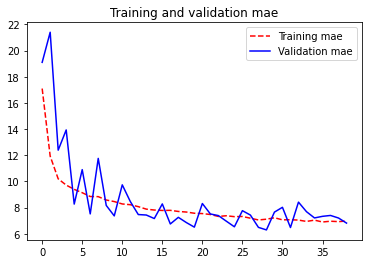

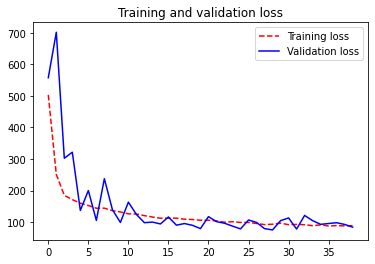

In [ ]:
plot_history(history5,'mae')

In [ ]:
score = model5.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])

Test loss: 80.80624389648438
Test mae: 6.744475841522217


#Different Architectures

Keras `Applications` module provides a variety of built-in deep learning models that are made available alongside pre-trained weights on imagenet dataset. These models can be used for prediction, feature extraction, and fine-tuning.

[Here is a link](https://keras.io/api/applications/) for the full list of the models and additional details.

But because these images with a size of 48X48X1, we can't use those built-in models in Keras. All of them require image size of aXaX3 (RGB, not just grayscale), therefore I will build "manually" VGG19 and ResNet50 architectures and do adjustments for our project data.   

## Using VGG19 model

VGG-19 is a trained Convolutional Neural Network, from Visual Geometry Group, Department of Engineering Science, University of Oxford. The number 19 stands for the number of layers with trainable weights. 16 Convolutional layers and 3 Fully Connected layers.

Reference [to the paper](https://arxiv.org/abs/1409.1556).


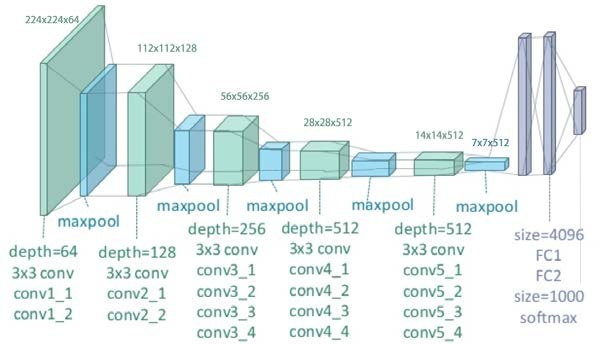

In [ ]:
from IPython.display import Image
Image('llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.png',width=1200)

### Create VGG19 model

In [ ]:
def VGG_19(last_activation='softmax',n_class=2, input_shape=(48,48,1), loss="binary_crossentropy", metric='accuracy', learning_rate=1e-3):
    model = Sequential([
                Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape),
                Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                MaxPooling2D((2,2)),

                Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                MaxPooling2D((2,2)),

                Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                MaxPooling2D((2,2)),

                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                MaxPooling2D((2,2)),
        
                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'),
                MaxPooling2D((2,2)),
        
        
                Flatten(),
                Dense(4096, activation='relu'),
                Dropout(0.5),
                Dense(4096, activation='relu'),
                Dropout(0.5),
                Dense(n_class, activation=last_activation)
                ])
    model.compile(optimizer= Adam(lr=learning_rate),
                  loss=loss,
                  metrics=[metric])
    
    return model

In [ ]:
model6 = VGG_19(last_activation='relu', n_class=1, loss="mean_squared_error", metric='mae')
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 256)      

In [ ]:
# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights6.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7 ,verbose=1)


steps_per_epoch = batches.n // batches.batch_size
validation_steps = val_batches.n // val_batches.batch_size

history6 = model6.fit_generator(batches,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=100,
                    validation_data = val_batches,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)


Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 7745.4907 - mae: 21.2042
Epoch 00001: val_loss improved from inf to 410.67041, saving model to weights6.h5
535/535 [==============================] - 15s 29ms/step - loss: 7745.4907 - mae: 21.2042 - val_loss: 410.6704 - val_mae: 15.6107
Epoch 2/100
535/535 [==============================] - ETA: 0s - loss: 400.9638 - mae: 15.3509
Epoch 00002: val_loss did not improve from 410.67041
535/535 [==============================] - 14s 26ms/step - loss: 400.9638 - mae: 15.3509 - val_loss: 410.9230 - val_mae: 15.0884
Epoch 3/100
535/535 [==============================] - ETA: 0s - loss: 399.7660 - mae: 15.3647
Epoch 00003: val_loss improved from 410.67041 to 399.75055, saving model to weights6.h5
535/535 [==============================] - 15s 28ms/step - loss: 399.7660 - mae: 15.3647 - val_loss: 399.7505 - val_mae: 15.5476
Epoch 4/100
535/535 [==============================] - ETA: 0s - loss: 386.8925 - mae: 15.1655
Epoch 00

The first 3 values of loss and validation loss are extremely high and interfere with the whole graph in the visualization therefore I adjust the function a little to fix this problem.

In [ ]:
def plot_history_fixed(History,Metric = 'accuracy'):
    metric = History.history[Metric][2:]
    val_metric = History.history['val_'+ str(Metric)][2:]
    loss = History.history['loss'][2:]
    val_loss = History.history['val_loss'][2:]
    epochs = range(len(metric))

    plt.plot(epochs, metric, 'r--', label='Training ' + str(Metric))
    plt.plot(epochs, val_metric, 'b', label='Validation ' + str(Metric))
    plt.title('Training and validation '+ str(Metric))
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

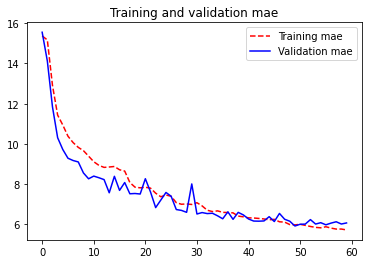

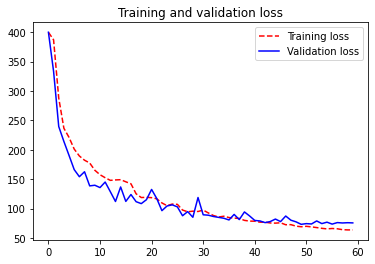

In [ ]:
plot_history_fixed(history6,'mae')

In [ ]:
score = model6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])

Test loss: 70.46290588378906
Test mae: 5.921878814697266


The mean absolute error (MAE) improved from 6.744 to 5.921!

#ResNet50 model

ResNet-50 is a deep residual network. The "50" refers to the number of layers it has. 

The main innovation of ResNet is the skip connection which help to overcome vanishing gradients problem (the gradient gets smaller and smaller) and allows the network go deeper. - reference [HERE](https://arxiv.org/abs/1512.03385)

Most of the code I took from [HERE](https://github.com/Kulbear/deep-learning-coursera/blob/master/Convolutional%20Neural%20Networks/Residual%20Networks%20-%20v1.ipynb) which is an implementation of ResNet50 architecture. Basically it's the answer for an assignment in the DeepLearning.AI course by Andrew Ng. For the original Keras team implementation code: [LINK](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py)




CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER


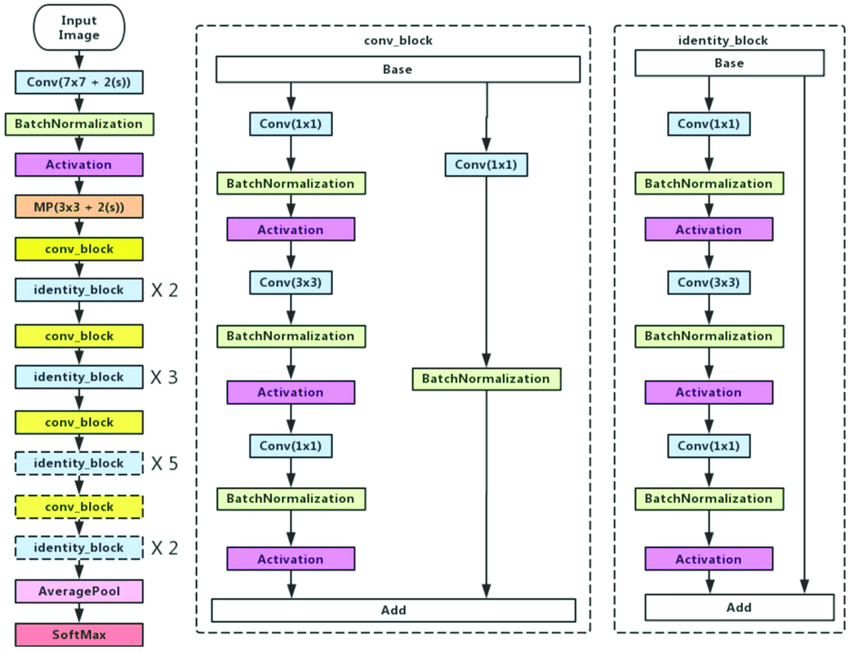

In [ ]:
from IPython.display import Image
Image('Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png',width=1200)

### Create ResNet50  model

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    #Shortcut path 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape=(48, 48, 1), classes=1):

   """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = keras.layers.AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='relu', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

### Test the Model

In [ ]:
model7 = ResNet50(input_shape = (48, 48, 1), classes = 1)

In [ ]:
model7.compile(optimizer= Adam(lr=0.001),loss="mean_squared_error", metrics=['mae'])

# Callbacks setting
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights7.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=1)


steps_per_epoch = batches.n // batches.batch_size
validation_steps = val_batches.n // val_batches.batch_size

history7 = model7.fit_generator(batches,
                    steps_per_epoch=steps_per_epoch,                    
                    epochs=100,
                    validation_data = val_batches,
                    validation_steps=validation_steps,
                    callbacks=[es, rlr, mcp],
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 306.5860 - mae: 13.1685
Epoch 00001: val_loss improved from inf to 216.44398, saving model to weights7.h5
535/535 [==============================] - 65s 122ms/step - loss: 306.5860 - mae: 13.1685 - val_loss: 216.4440 - val_mae: 10.9160
Epoch 2/100
535/535 [==============================] - ETA: 0s - loss: 219.4452 - mae: 10.9828
Epoch 00002: val_loss did not improve from 216.44398
535/535 [==============================] - 61s 114ms/step - loss: 219.4452 - mae: 10.9828 - val_loss: 242.1119 - val_mae: 11.4541
Epoch 3/100
535/535 [==============================] - ETA: 0s - loss: 194.2066 - mae: 10.2045
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 00003: val_loss did not improve from 216.44398
535/535 [==============================] - 61s 114ms/step - loss: 194.2066 - mae: 10.2045 - val_loss: 613.2628

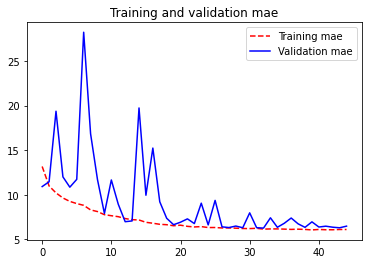

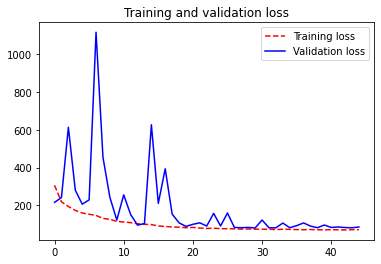

In [ ]:
plot_history(history7,'mae')

In [ ]:
score = model7.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])

Test loss: 78.32403564453125
Test mae: 6.300170421600342


The mean absolute error (MAE) dosent improved from the previose model (MAE: 5.921).

#Summary

### Gender:

- Fully connected layer model with 4 layers, 80 neurons each, Accuracy: 83.712%
- Convolutional model, Accuracy: 90.09%
- Convolutional model with data augmentation, Accuracy: 92.4 **best**

### Ethnicity:

- Convolutional model with data augmentation, F1 score: 82.54% **best**


### Age:

Note: With data augmentation Throughout.
- Convolutional model, MAE: 6.744
- VGG19, MAE: 5.921 **best**
- ResNet50, MAE: 6.3

